# Predicción de la demanda de bicicletas compartidas en Seul
Este jupuyter notebook tiene como objetivo probar distintos algóritmos de machine learning para predecir la demanda de bicicletas compartidas en Seul. Para esto se llevaran a cabo las distintas etapas de un proyecto de Machine Learning y Data Science, como lo son el analisis exploratorio de los datos, preprocesado y feature engineering. Por último, se compararan los resultados da cada modelo para escoger el modelo con mayor rendimiento y realizar el tuneo de hiperparámetros buscando optimizar el modelo.

Los datos fueron extraidos de la pagina web `UCI Machine Learning Repository`, puedes descargar el dataset en el siguiente link: https://archive-beta.ics.uci.edu/dataset/560/seoul+bike+sharing+demand 

In [24]:
#lo basico
import pandas as pd
import numpy as np
from scipy.stats import stats, skew, kurtosis, probplot
import pickle

#visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
import plotly.express as px
import plotly.graph_objects as go

#pre-procesado
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

#Metricas
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Modelado
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Tuneo de modelos
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')


### Cargar dataset

In [2]:
#Cargar el dataset
df_demand_bikes = pd.read_csv('SeoulBikeData.csv', parse_dates=['Date'], dayfirst=True, encoding='ISO-8859-1')

### EDA

In [3]:
# Dimension del Dataset
print(f'El dataset tiene {df_demand_bikes.shape[0]} filas y {df_demand_bikes.shape[1]} columnas.')

El dataset tiene 8760 filas y 14 columnas.


In [4]:
df_demand_bikes.head()

Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0 2017-12-01                254     0             -5.2           37   
1 2017-12-01                204     1             -5.5           38   
2 2017-12-01                173     2             -6.0           39   
3 2017-12-01                107     3             -6.2           40   
4 2017-12-01                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   

  Functioning Day  
0             Yes  
1             Yes  
2             Yes  
3             Yes  
4             Yes

In [5]:
df_demand_bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8760 non-null   datetime64[ns]
 1   Rented Bike Count          8760 non-null   int64         
 2   Hour                       8760 non-null   int64         
 3   Temperature(°C)            8760 non-null   float64       
 4   Humidity(%)                8760 non-null   int64         
 5   Wind speed (m/s)           8760 non-null   float64       
 6   Visibility (10m)           8760 non-null   int64         
 7   Dew point temperature(°C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)    8760 non-null   float64       
 9   Rainfall(mm)               8760 non-null   float64       
 10  Snowfall (cm)              8760 non-null   float64       
 11  Seasons                    8760 non-null   object        
 12  Holida

In [6]:
# Revisar la presencia de valores nulos
print(df_demand_bikes.isnull().sum())

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64


no hay presencia de valores nulos declarados 

##### Observar como se distribuye la variable objetivo 

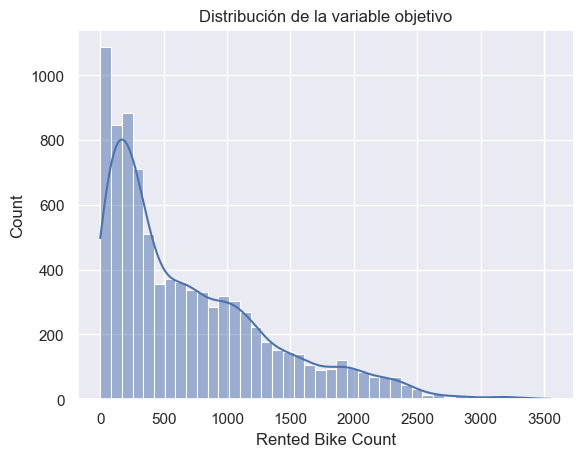

Media: 704.602, Mediana: 504.500
Coeficiente de asimetría: 1.153
Coeficiente de curtosis (Fisher): 0.852


In [3]:
# Histograma
sns.histplot(df_demand_bikes['Rented Bike Count'], kde=True)
plt.title('Distribución de la variable objetivo')
plt.show()
mean_demand = df_demand_bikes['Rented Bike Count'].mean()
median_demand = df_demand_bikes['Rented Bike Count'].median()
skewness = skew(df_demand_bikes['Rented Bike Count'])
kurt = kurtosis(df_demand_bikes['Rented Bike Count'])
print(f'Media: {mean_demand:.3f}, Mediana: {median_demand:.3f}') 
print(f'Coeficiente de asimetría: {skewness:.3f}')
print(f'Coeficiente de curtosis (Fisher): {kurt:.3f}')


Media superior a la mediana, la distribución presenta asimetría positiva 

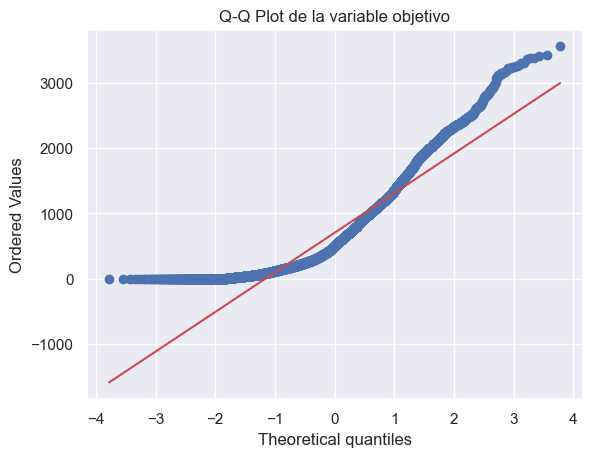

In [ ]:
probplot(df_demand_bikes['Rented Bike Count'], dist="norm", plot=plt)
plt.title('Q-Q Plot de la variable objetivo')
plt.show()

##### Continuamos con el EDA


In [9]:
# Revisar Cardinalidad
df_demand_bikes.nunique()

Date                          365
Rented Bike Count            2166
Hour                           24
Temperature(°C)               546
Humidity(%)                    90
Wind speed (m/s)               65
Visibility (10m)             1789
Dew point temperature(°C)     556
Solar Radiation (MJ/m2)       345
Rainfall(mm)                   61
Snowfall (cm)                  51
Seasons                         4
Holiday                         2
Functioning Day                 2
dtype: int64

In [10]:
# Observar cuales son las etiquetas de cada variable categórica
for i in df_demand_bikes.columns:
    if df_demand_bikes[i].dtype == 'object':
        print(f'Valores únicos de la variable {i}: {df_demand_bikes[i].unique()}')

Valores únicos de la variable Seasons: ['Winter' 'Spring' 'Summer' 'Autumn']
Valores únicos de la variable Holiday: ['No Holiday' 'Holiday']
Valores únicos de la variable Functioning Day: ['Yes' 'No']


In [11]:
# Observar la cantidad de registros de las etiquetas de cada variable categórica
for i in df_demand_bikes.columns:
    if df_demand_bikes[i].dtype == 'object':
        print(df_demand_bikes[i].value_counts())

Seasons
Spring    2208
Summer    2208
Autumn    2184
Winter    2160
Name: count, dtype: int64
Holiday
No Holiday    8328
Holiday        432
Name: count, dtype: int64
Functioning Day
Yes    8465
No      295
Name: count, dtype: int64


In [12]:
df_demand_bikes.describe(exclude=np.number)

Date Seasons     Holiday Functioning Day
count                            8760    8760        8760            8760
unique                            NaN       4           2               2
top                               NaN  Spring  No Holiday             Yes
freq                              NaN    2208        8328            8465
mean    2018-05-31 23:59:59.999999744     NaN         NaN             NaN
min               2017-12-01 00:00:00     NaN         NaN             NaN
25%               2018-03-02 00:00:00     NaN         NaN             NaN
50%               2018-06-01 00:00:00     NaN         NaN             NaN
75%               2018-08-31 00:00:00     NaN         NaN             NaN
max               2018-11-30 00:00:00     NaN         NaN             NaN

In [3]:
def plot_categorical_distributions(df, exclude_col=None):
    """
    Función para graficar las distribuciones de las variables categóricas de un DataFrame.

    Args:
    - df (pd.DataFrame): El DataFrame que contiene las variables categóricas.
    - exclude_col (str, opcional): Nombre de la columna a excluir de los gráficos. Por defecto, None.

    Returns:
    - None: Muestra los gráficos de las variables categóricas.
    """
   
    cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
    # Excluir una columna específica si se proporciona
    if exclude_col and exclude_col in cat_cols:
        cat_cols = [col for col in cat_cols if col != exclude_col]

    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 10))
    axs = axs.flatten()

    index = 0
    for k, v in df[cat_cols].items():
        order = df[k].value_counts().index # Ordenar etiquetas por frecuencia descendente
        palette = sns.color_palette('Set2') # Crear una paleta de colores
        sns.countplot(data=df, x=v, ax=axs[index], palette=palette, order=order)
        axs[index].tick_params(axis='x', rotation=0, colors='black') # Rotar etiquetas del eje x
        index += 1

    
    plt.tight_layout(pad=0.5, w_pad=1.5, h_pad=4.0)
    plt.show()

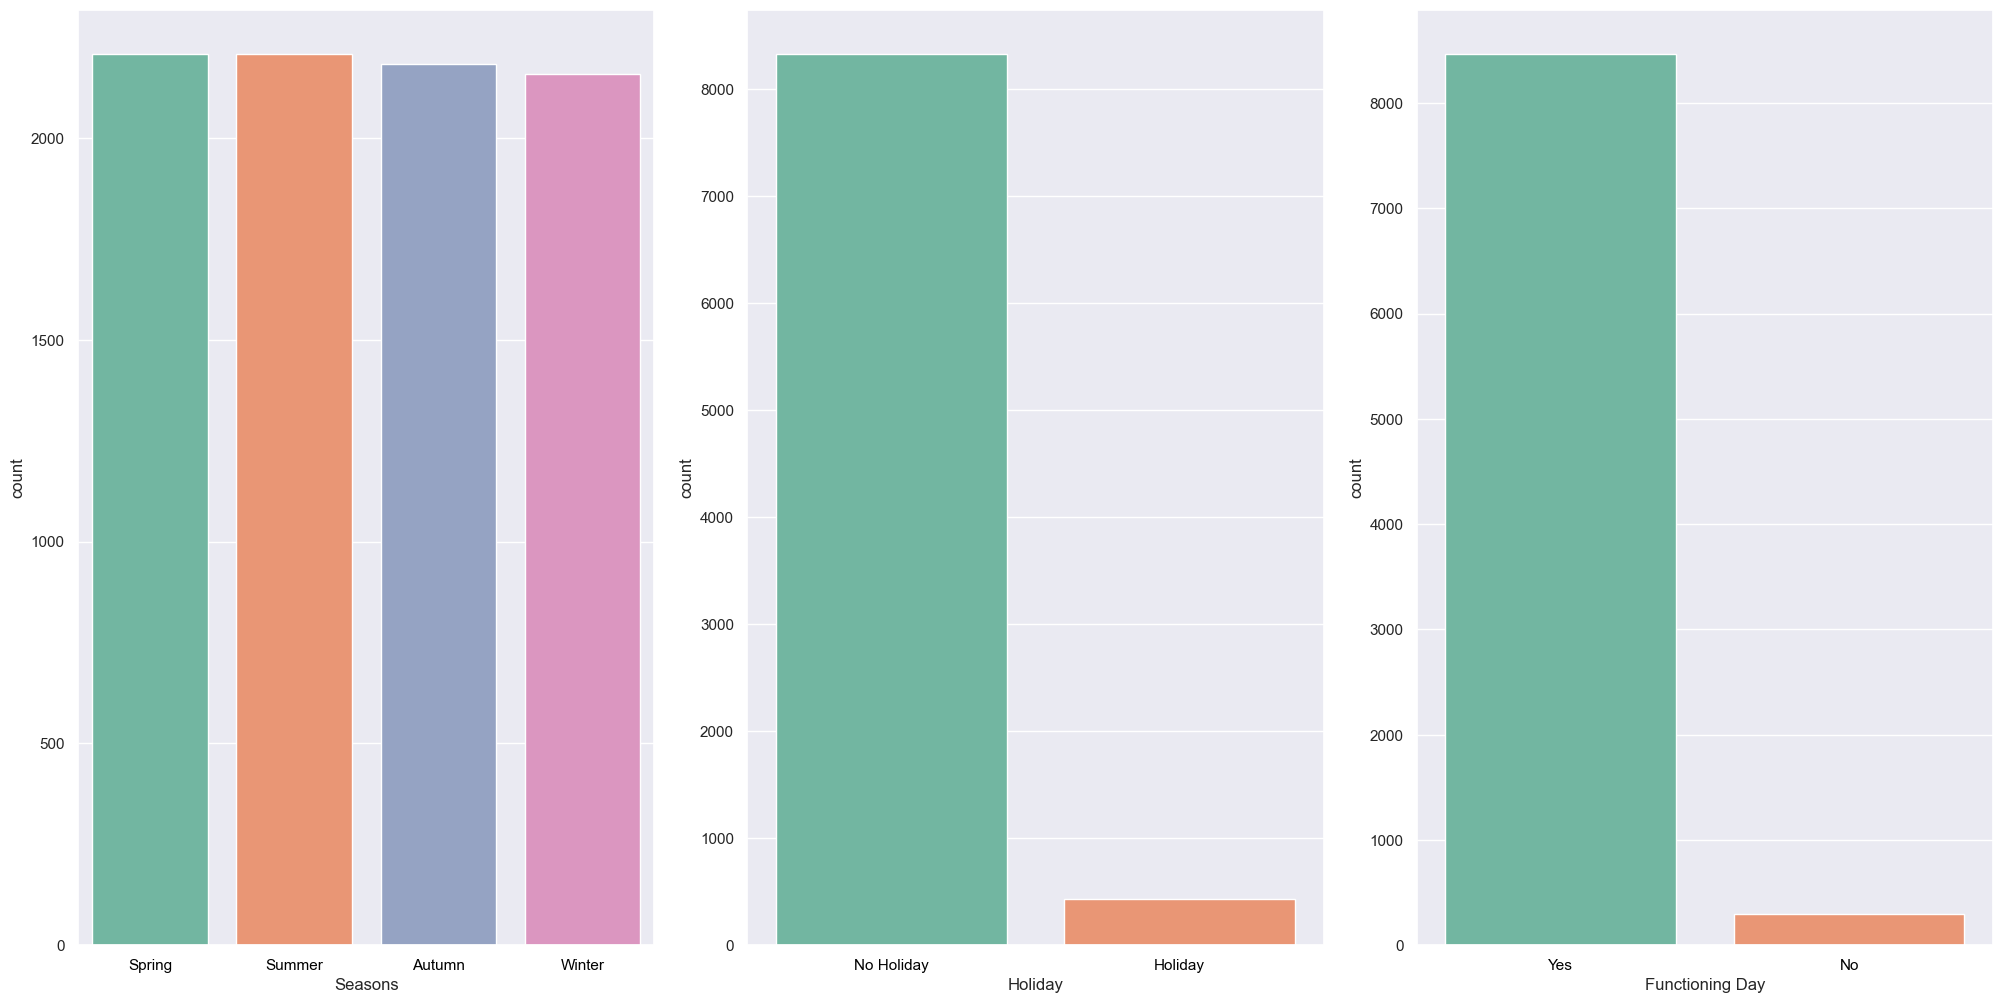

In [18]:
plot_categorical_distributions(df_demand_bikes, exclude_col='Date')

##### Explorar como se relacionan las variables categoricas con la variable objetivo

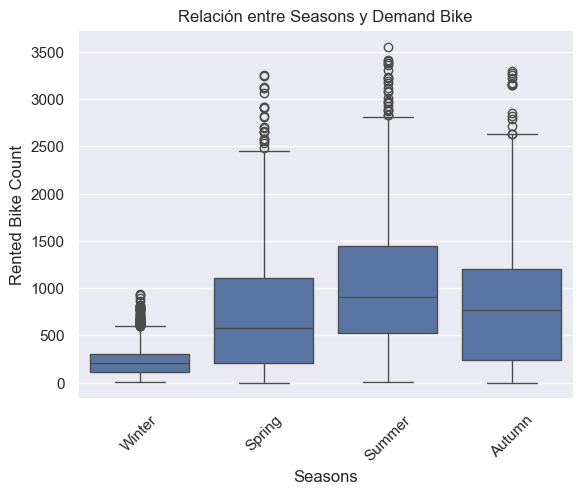

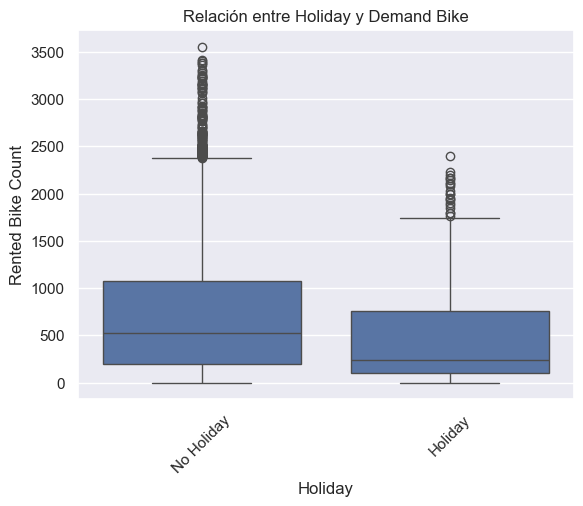

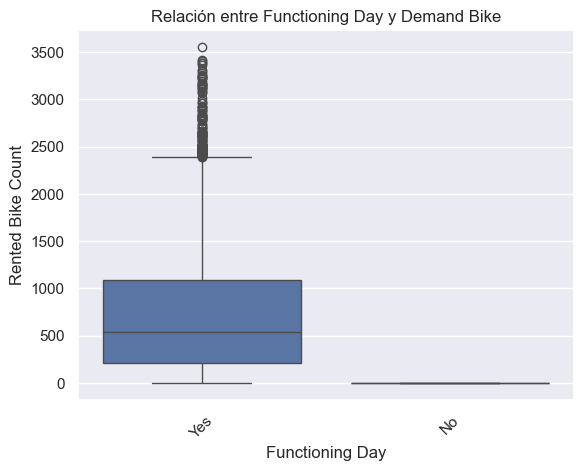

In [14]:
for col in df_demand_bikes.select_dtypes(include='object').columns:
    sns.boxplot(data=df_demand_bikes, x=col, y='Rented Bike Count')
    plt.title(f'Relación entre {col} y Demand Bike')
    plt.xticks(rotation=45)
    plt.show()

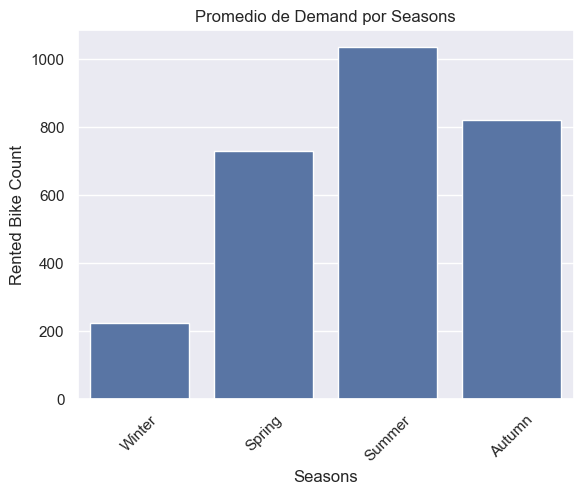

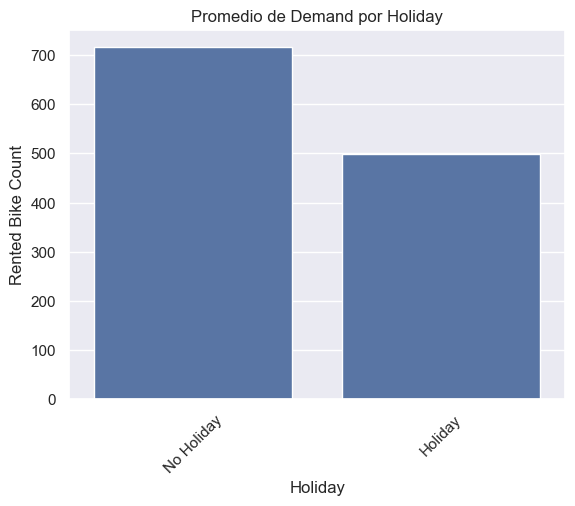

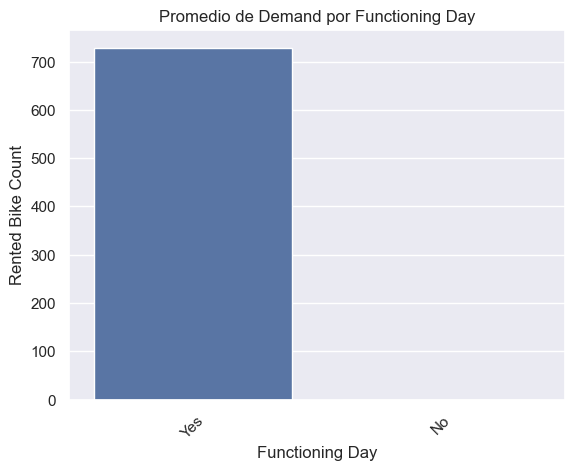

In [6]:
for col in df_demand_bikes.select_dtypes(include='object').columns:
    sns.barplot(data=df_demand_bikes, x=col, y='Rented Bike Count', ci=None)
    plt.title(f'Promedio de Demand por {col}')
    plt.xticks(rotation=45)
    plt.show()

##### Explorar como se distribuyen las variables numéricas y la presencia de valores atípicos (outliers)

In [4]:
def plot_histogram_and_boxplot(df, numeric_cols):
    """
    Grafica un histograma y un boxplot para cada variable numérica en un DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame que contiene las variables numéricas.
    - numeric_cols (list): Lista de nombres de las columnas numéricas.

    Returns:
    - None: Muestra los gráficos.
    """
    for col in numeric_cols:
        plt.figure(figsize=(12, 6))
        
        # Histograma
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, bins=20, color='blue')
        plt.title(f'Histograma de {col}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        
        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col], color='orange')
        plt.title(f'Boxplot de {col}')
        plt.xlabel(col)
        
        plt.tight_layout()
        plt.show()

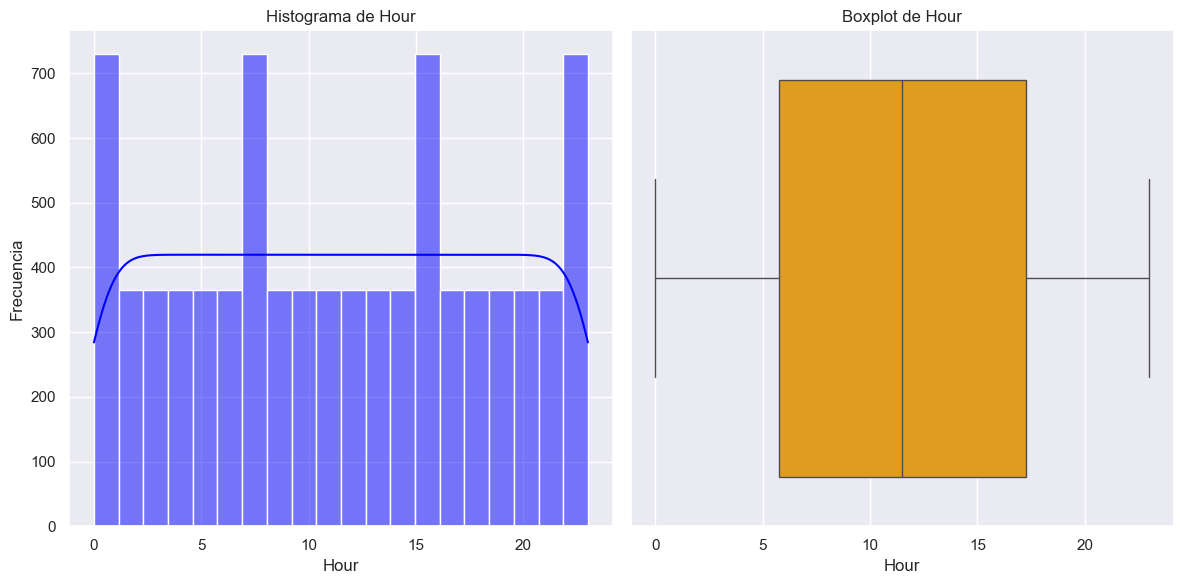

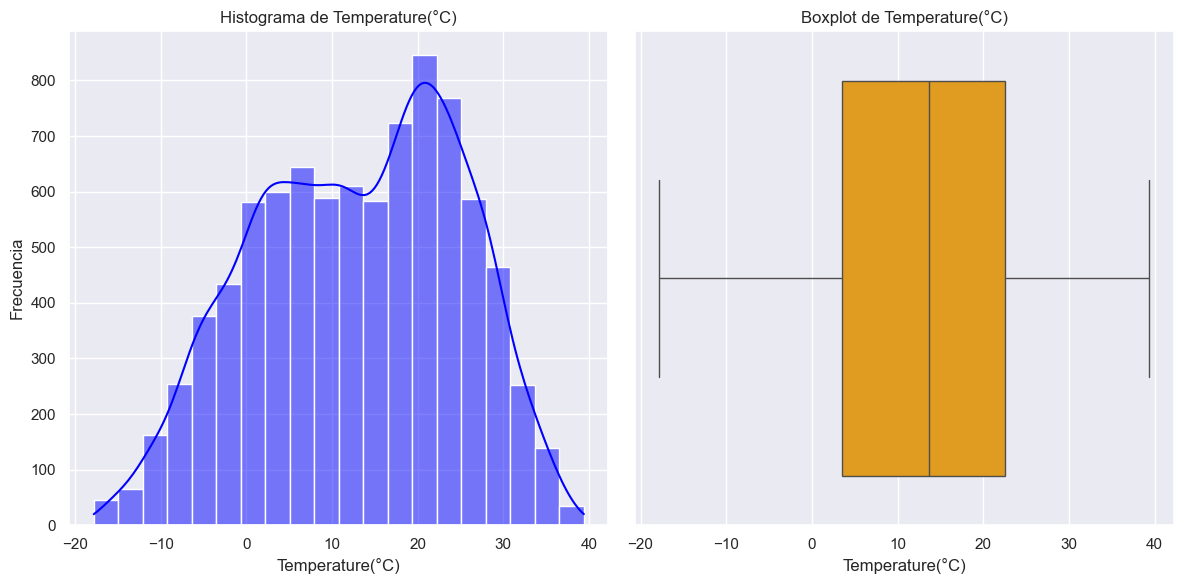

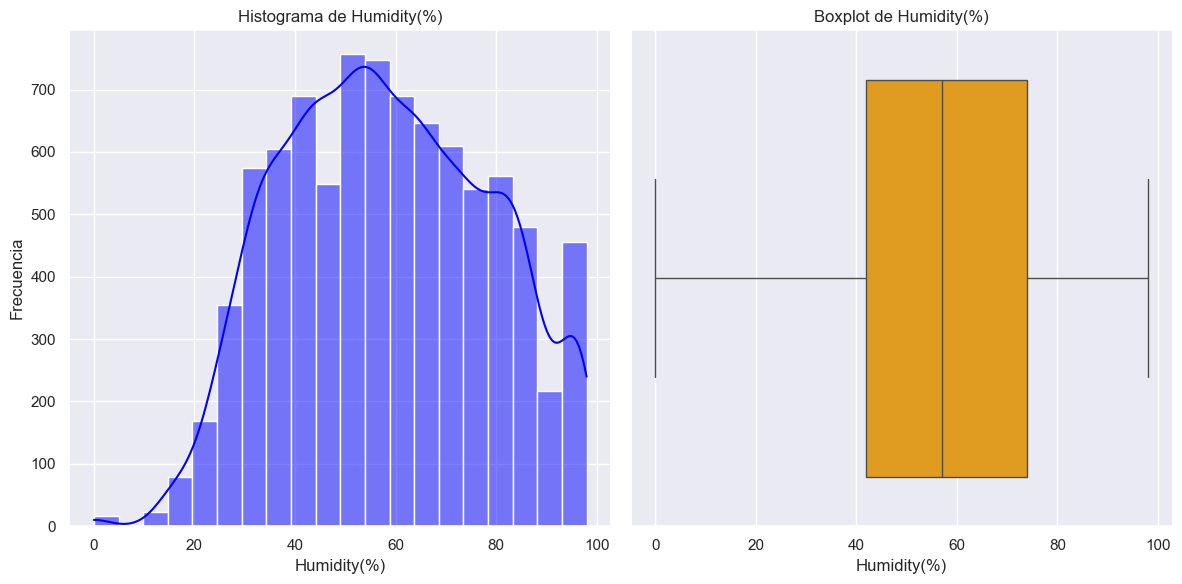

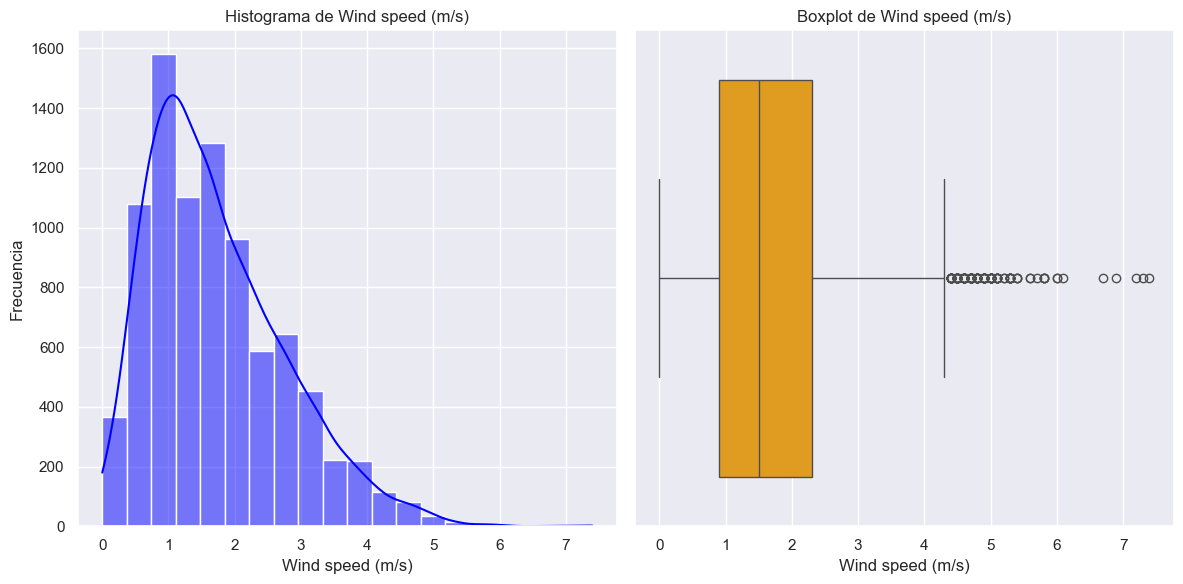

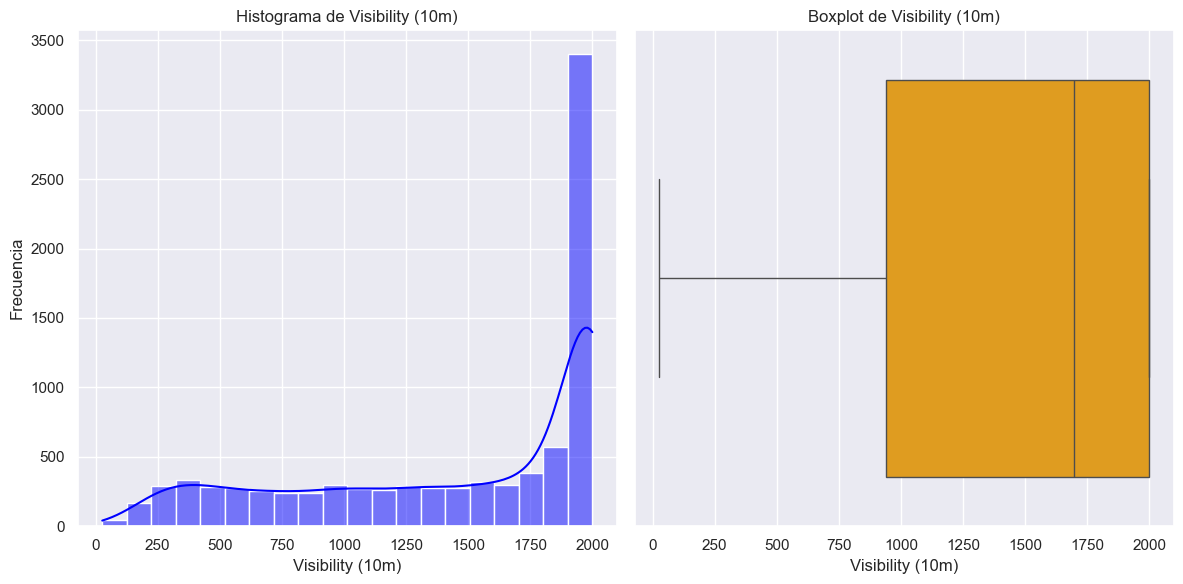

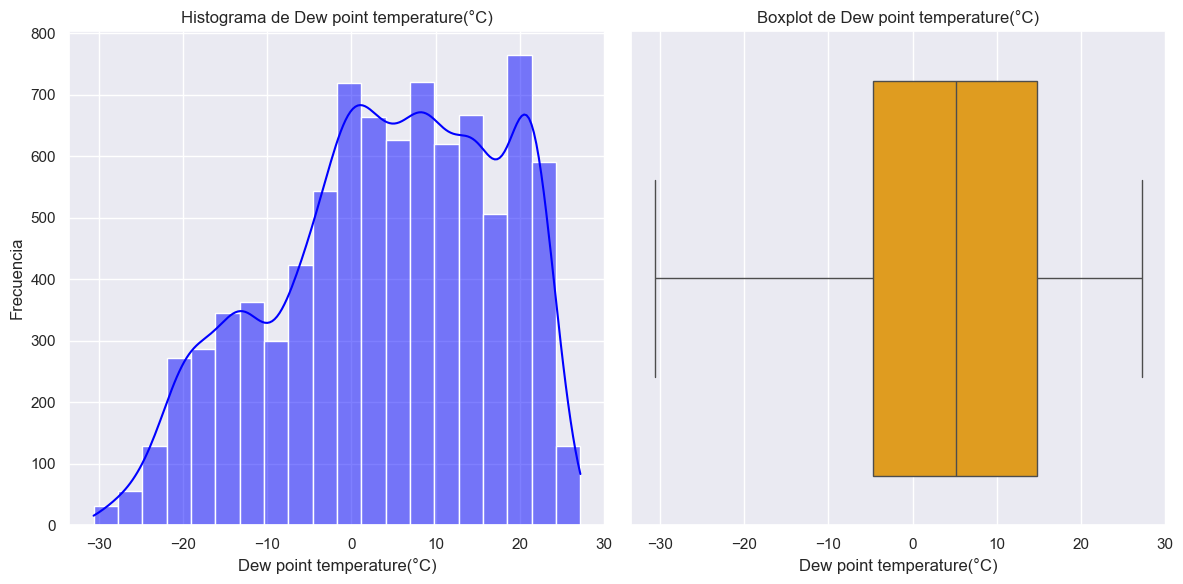

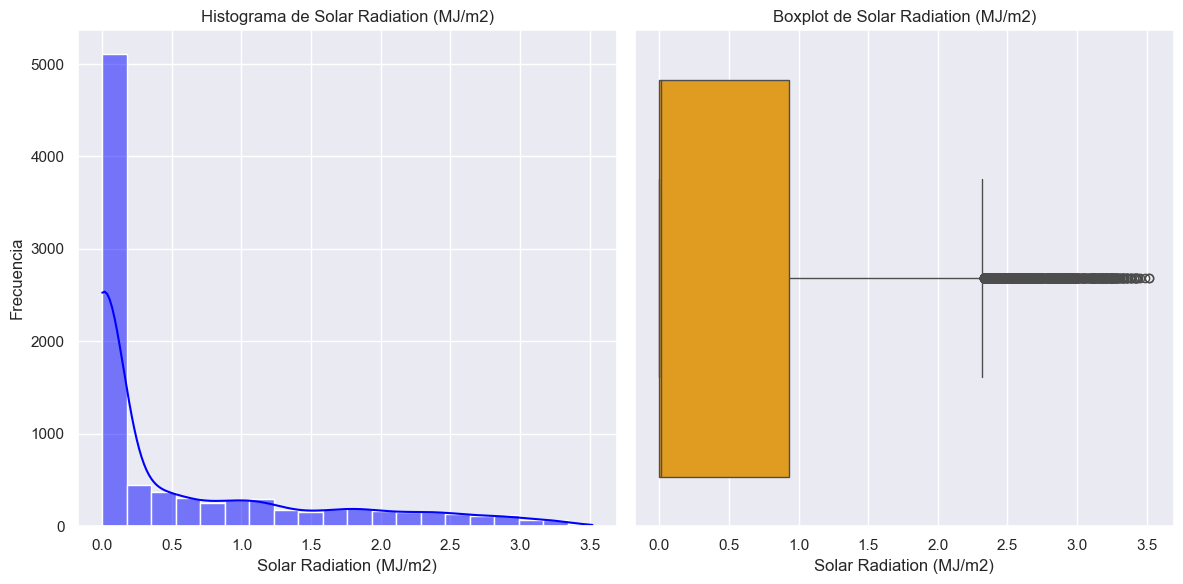

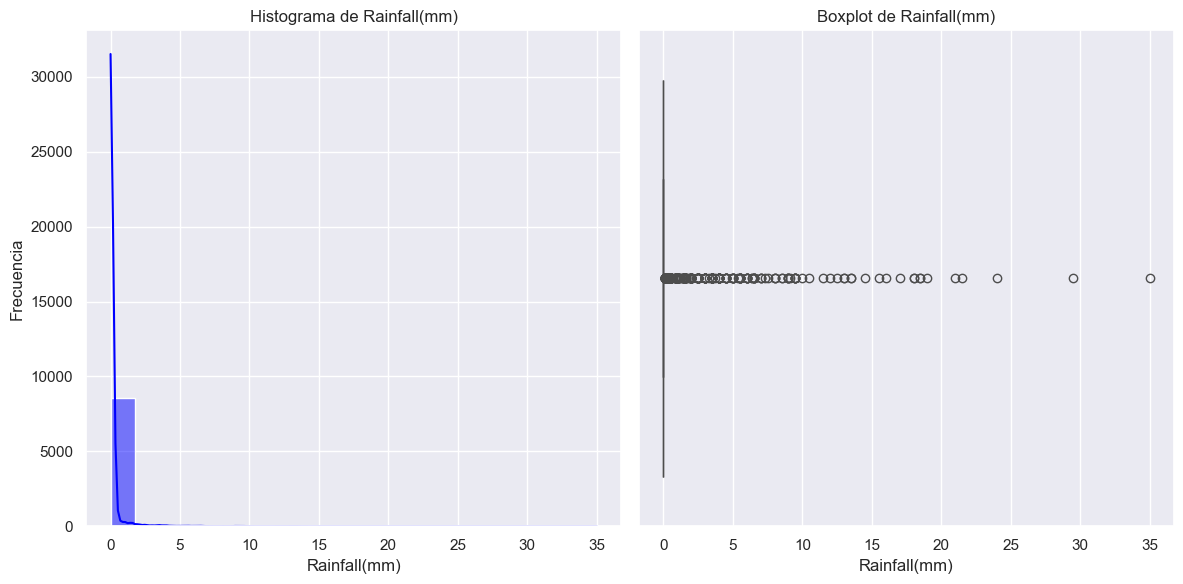

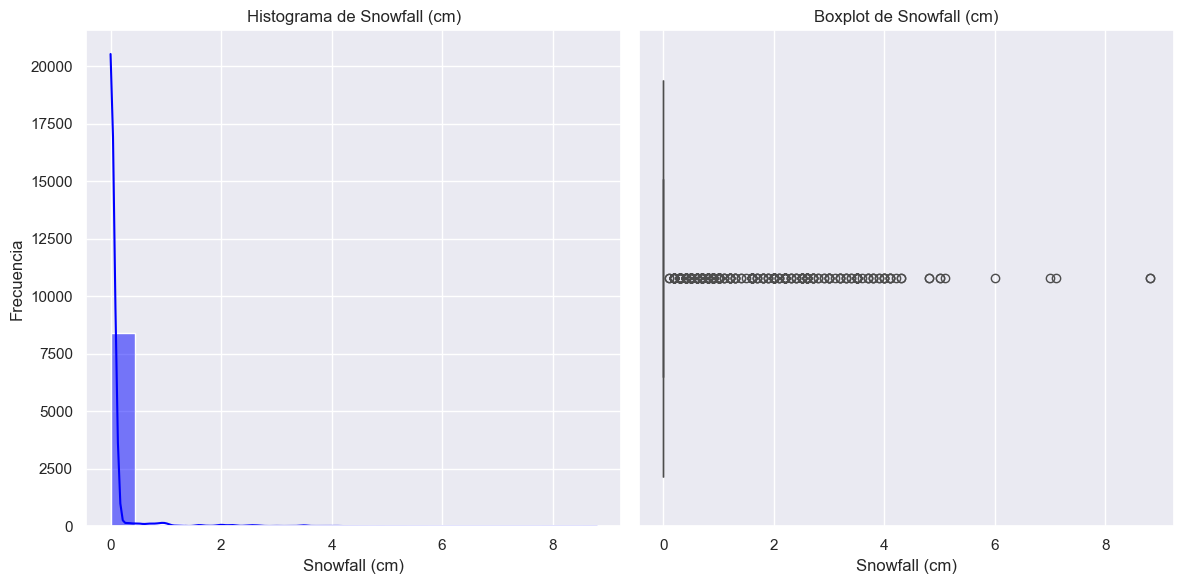

In [6]:
numeric_cols = df_demand_bikes.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('Rented Bike Count')

plot_histogram_and_boxplot(df_demand_bikes, numeric_cols)

##### Explorar relación entre las variables númericas y la variable Objetivo

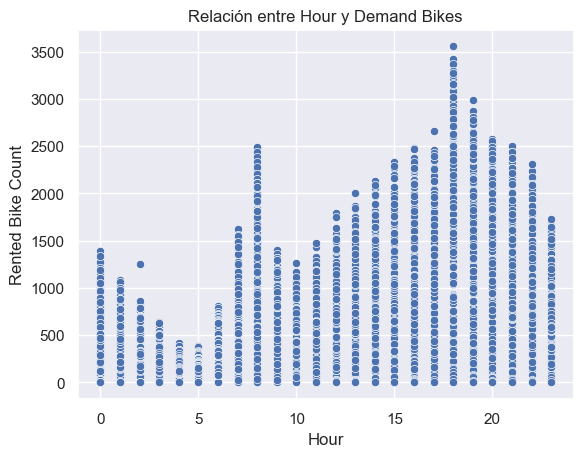

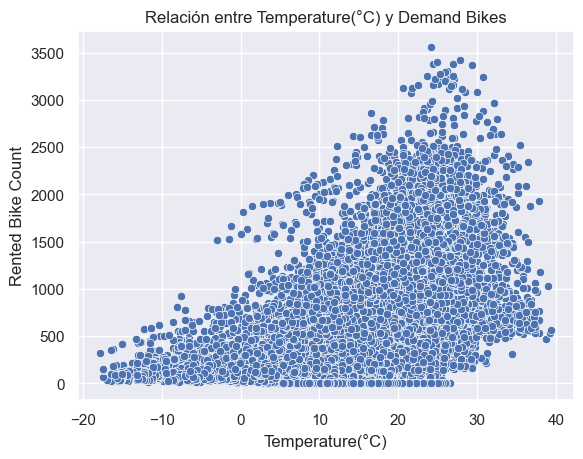

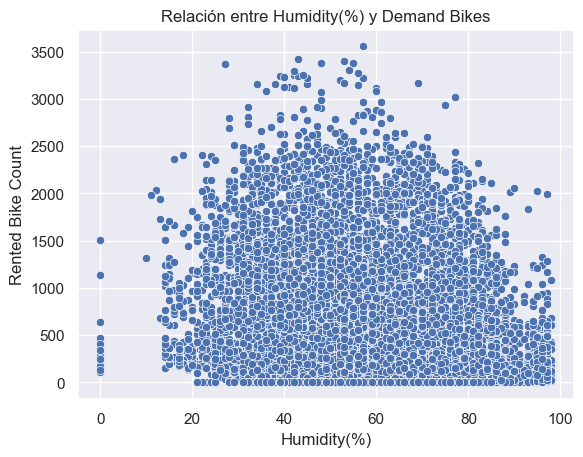

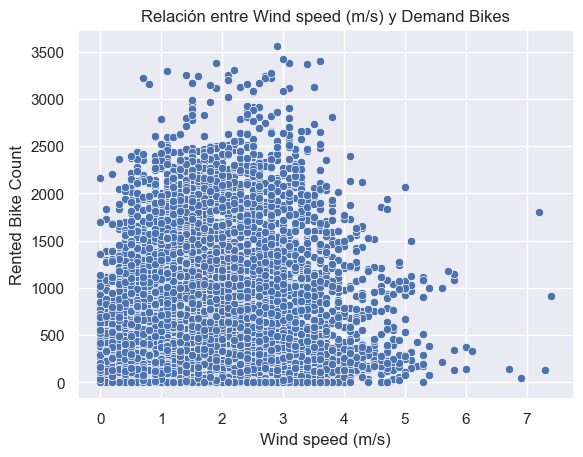

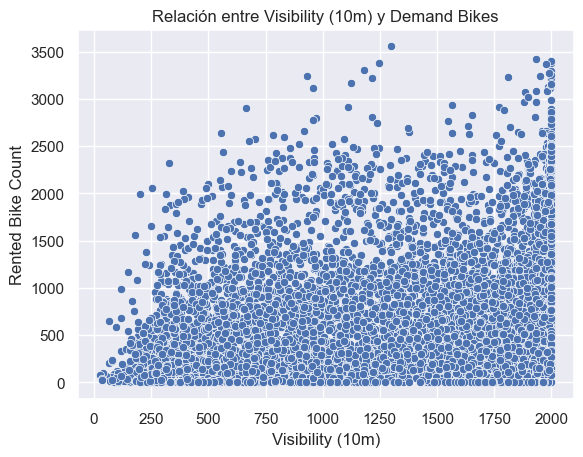

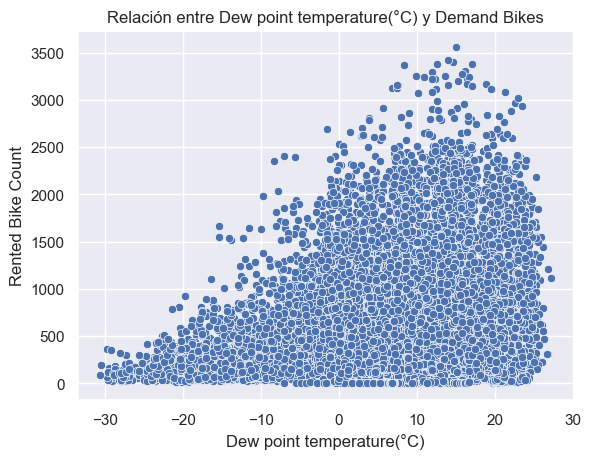

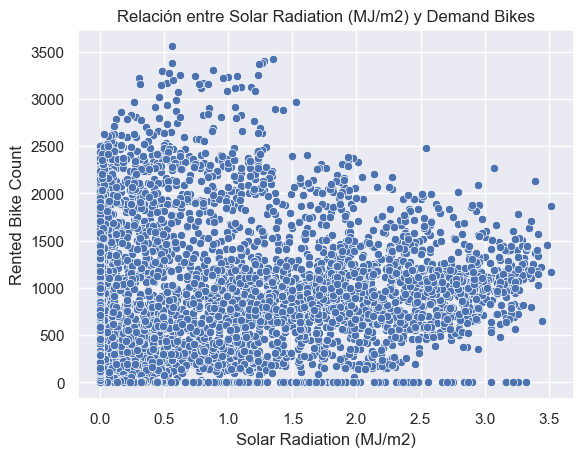

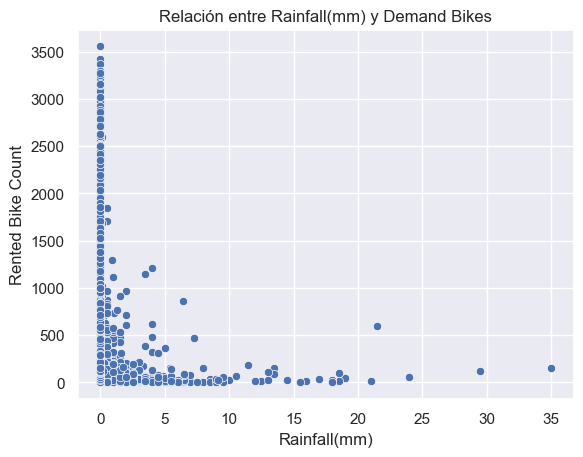

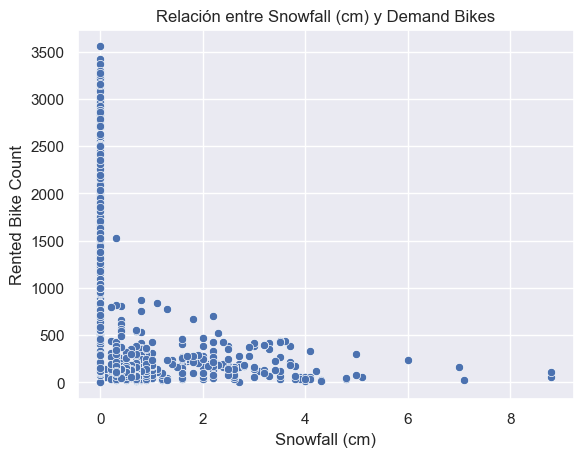

In [25]:
for col in df_demand_bikes.select_dtypes(include=np.number).columns:
    if col != 'Rented Bike Count':  # Reemplaza 'Demand' con el nombre de tu variable objetivo
        sns.scatterplot(data=df_demand_bikes, x=col, y='Rented Bike Count')
        plt.title(f'Relación entre {col} y Demand Bikes')
        plt.show()

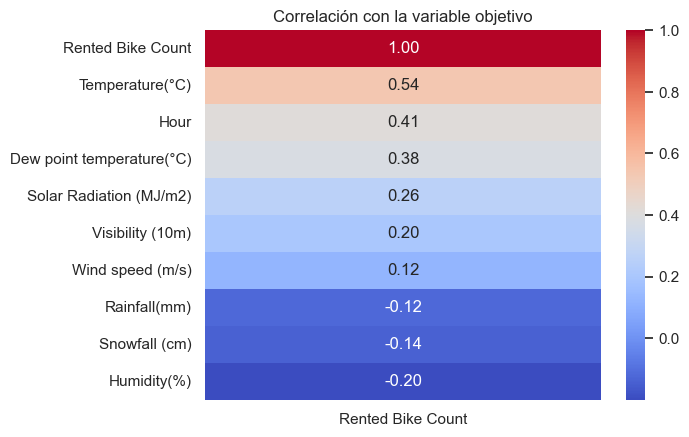

In [5]:
# Filtrar solo las columnas numéricas
numeric_cols = df_demand_bikes.select_dtypes(include=np.number)

# Calcular la correlación
corr = numeric_cols.corr()

# Graficar el heatmap
sns.heatmap(corr[['Rented Bike Count']].sort_values(by='Rented Bike Count', ascending=False), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlación con la variable objetivo')
plt.show()

pairplot para ver como se relacionan las distintas variables explicativas 

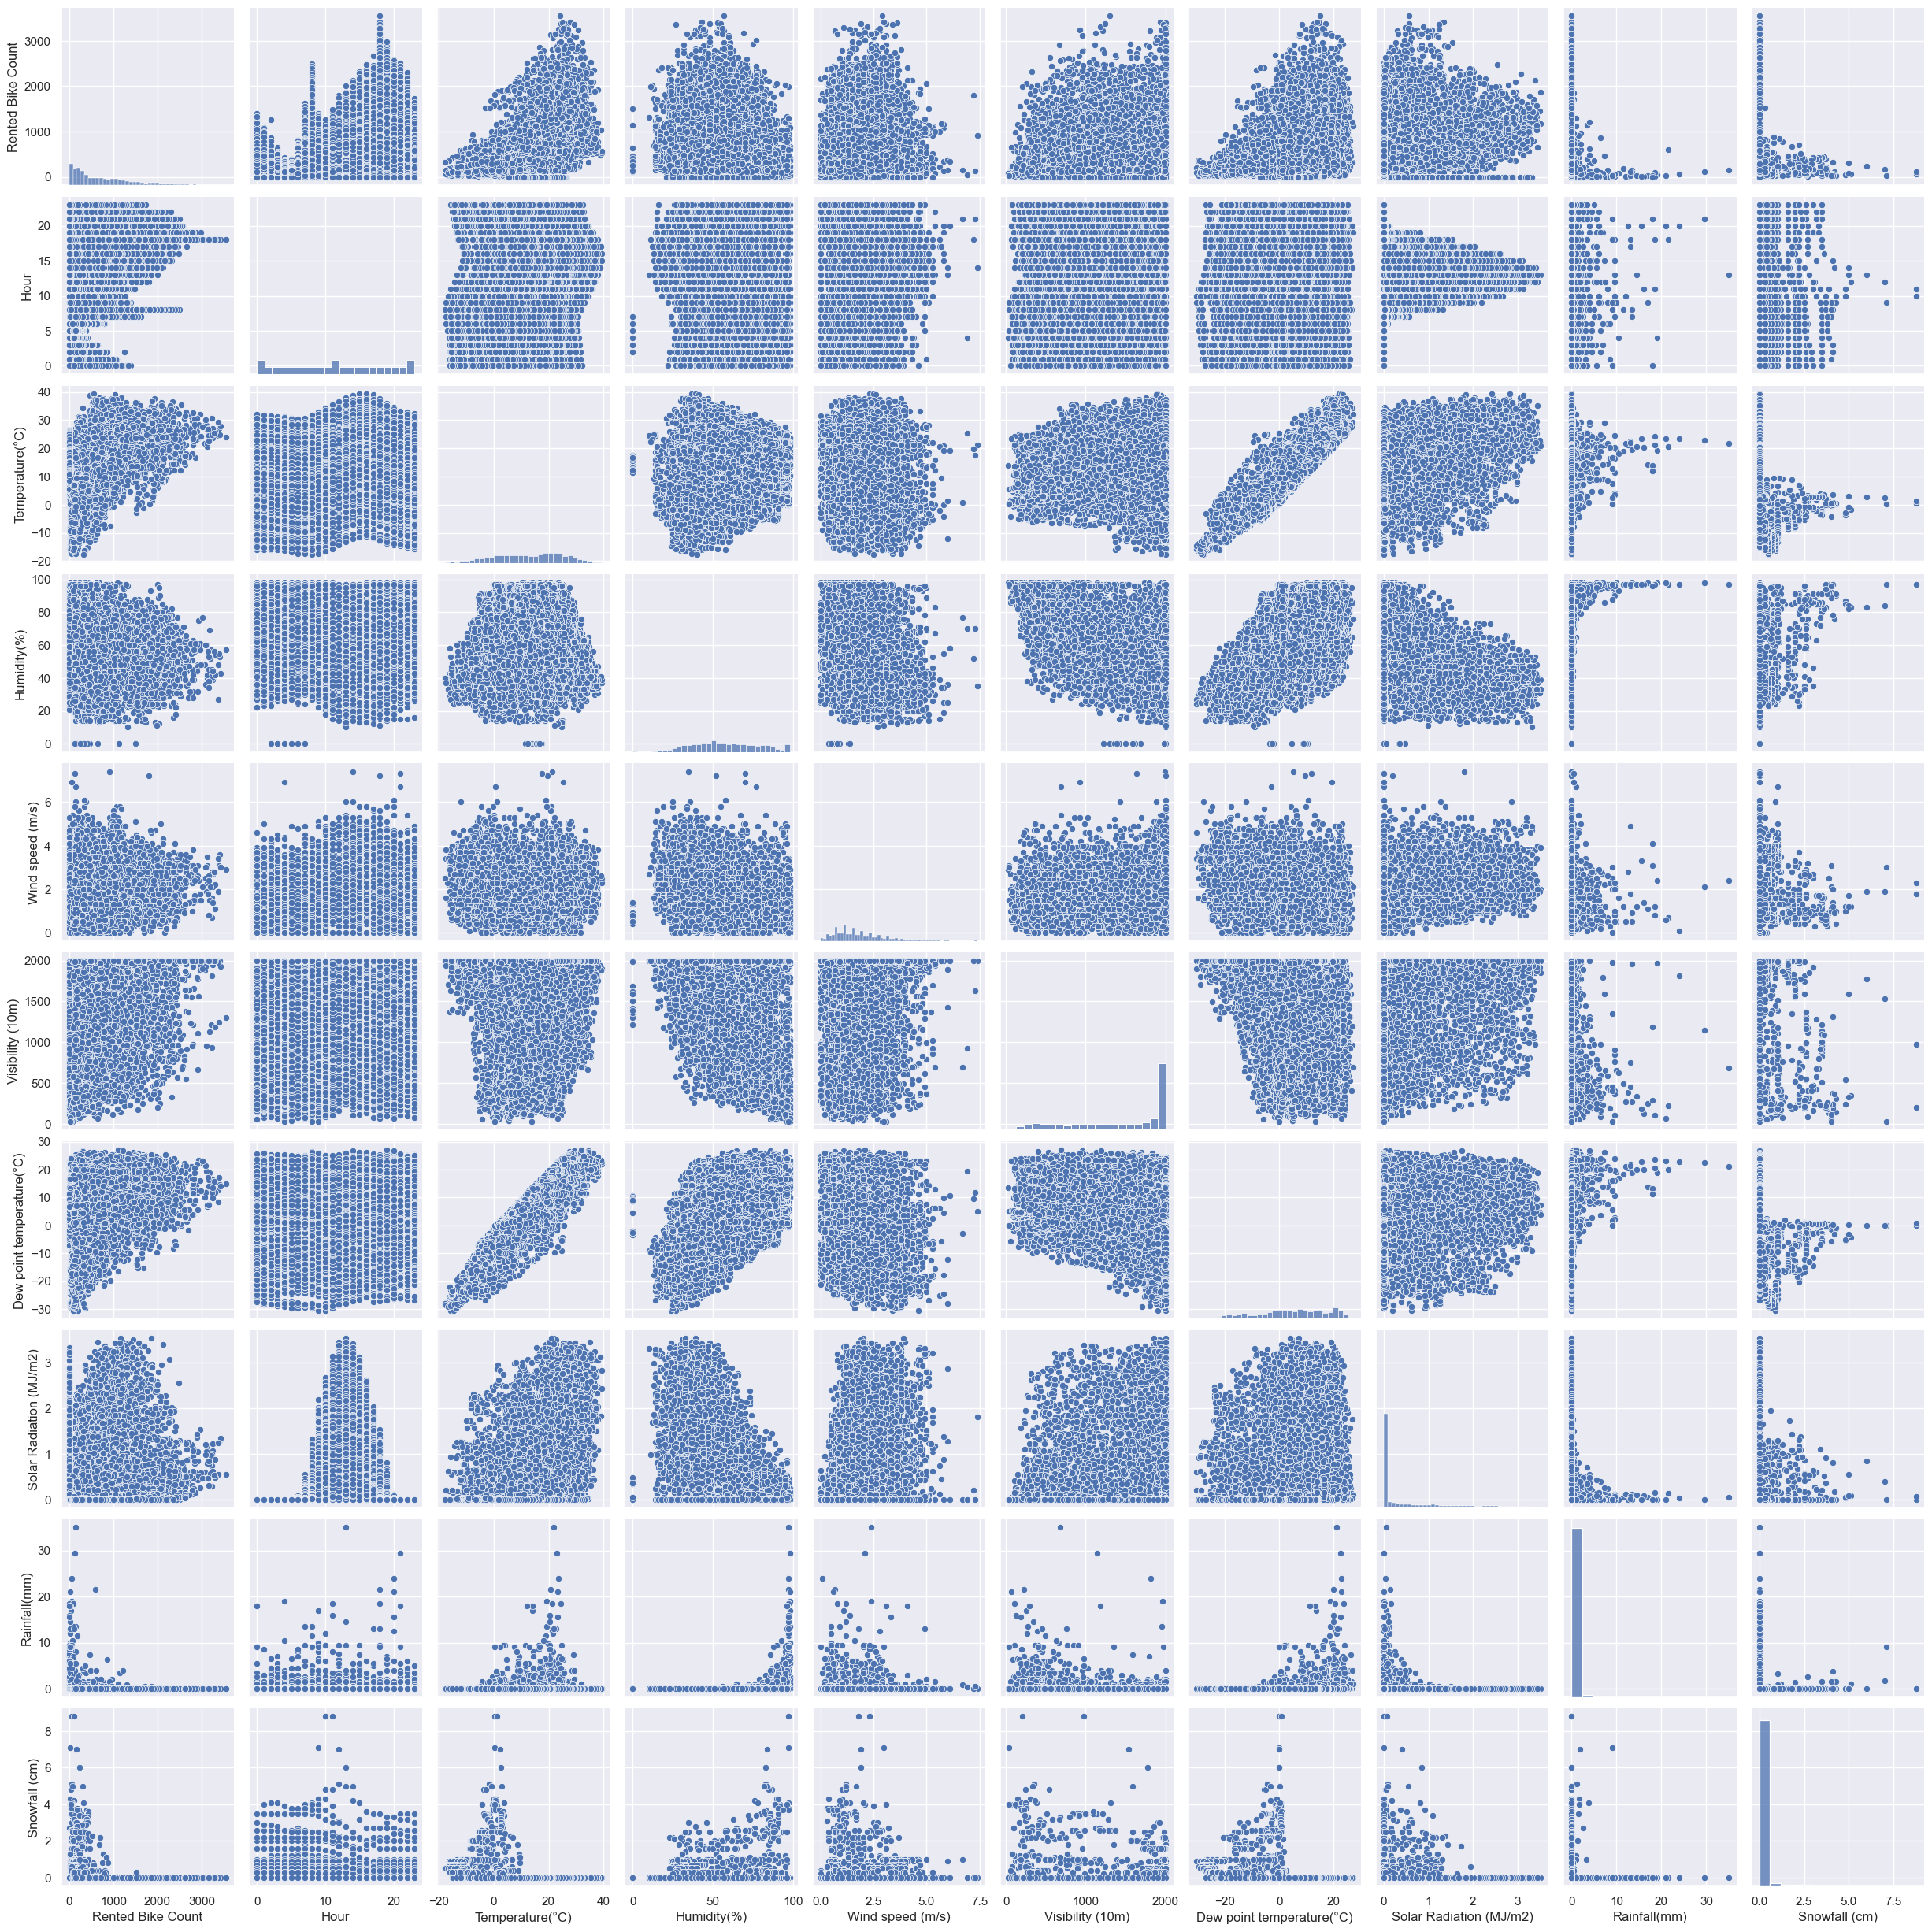

In [30]:
sns.pairplot(df_demand_bikes, y_vars=df_demand_bikes.select_dtypes(include=np.number).columns, x_vars=df_demand_bikes.select_dtypes(include=np.number).columns)
plt.show()



### Aspectos más relevantes observados durante el EDA
- Se observo una correlación positiva entre la temperatura y la demanda de bicicletas, lo cual también se ve reflejado en el boxplot y gráfico de barras que segmenta los datos por las estaciones del año, donde se observa que en las estaciones con una mayor temperatura hay una mayor demanda. Sin embargo, esta relacion no es lineal, ya que los días con picos de alta temperatura se evidencia una disminucion de la demanda.

- La variable `Temperature` y `Dew point Temperature` tienen una fuerte correlación positiva, si se empleara un modelo de regresión lineal habría que tener cuidado si se usan ambas variables como predictores, ya que pudieran ocasionar un problema de multicolinealidad.

- Otra observcion relevante del análisis exploratorio, es que la mayoria de las variables explicativas no tiene una relacion lineal con la variable objetivo, esto parece indicar que una regresión lineal no sería el modelo mas prometedor para este conjunto de datos.

In [4]:
# crear timestamp completo para usar en el split
df_demand_bikes['DateTime'] = df_demand_bikes['Date'] + pd.to_timedelta(df_demand_bikes['Hour'], unit='h')

#Borrar 'Date' ya que es redundante
df_demand_bikes = df_demand_bikes.drop('Date', axis=1)

df_demand_bikes[['DateTime', 'Hour']].head(24)

DateTime  Hour
0  2017-12-01 00:00:00     0
1  2017-12-01 01:00:00     1
2  2017-12-01 02:00:00     2
3  2017-12-01 03:00:00     3
4  2017-12-01 04:00:00     4
5  2017-12-01 05:00:00     5
6  2017-12-01 06:00:00     6
7  2017-12-01 07:00:00     7
8  2017-12-01 08:00:00     8
9  2017-12-01 09:00:00     9
10 2017-12-01 10:00:00    10
11 2017-12-01 11:00:00    11
12 2017-12-01 12:00:00    12
13 2017-12-01 13:00:00    13
14 2017-12-01 14:00:00    14
15 2017-12-01 15:00:00    15
16 2017-12-01 16:00:00    16
17 2017-12-01 17:00:00    17
18 2017-12-01 18:00:00    18
19 2017-12-01 19:00:00    19
20 2017-12-01 20:00:00    20
21 2017-12-01 21:00:00    21
22 2017-12-01 22:00:00    22
23 2017-12-01 23:00:00    23

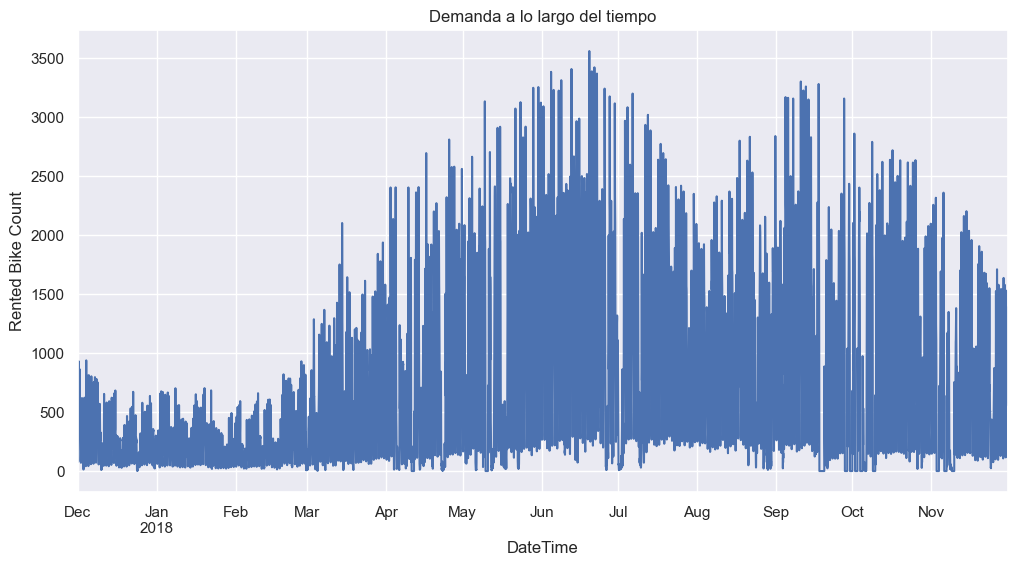

In [4]:
# Grafico Temporal
df_demand_bikes.set_index('DateTime')['Rented Bike Count'].plot(figsize=(12, 6))
plt.title('Demanda a lo largo del tiempo')
plt.ylabel('Rented Bike Count')
plt.show()

### Feature engineering y pre-procesado

Se filtraran la filas donde 'Functioning Day' es 'Yes', es decir, los días en que la bicicleta estaba disponible para alquilar. Ya que en los días que no estaba disponible, 
la variable objetivo 'Rented Bike Count' es 0, lo que podria sesgar el análisis y el modelo predictivo.

In [5]:
# Filtrar las filas donde 'Functioning Day' es 'Yes'
df_demand_bikes = df_demand_bikes[df_demand_bikes['Functioning Day'] == 'Yes']

# Borrar columna 'Functioning Day' ya que ahora es redundante
df_demand_bikes = df_demand_bikes.drop('Functioning Day', axis=1)

In [6]:
# Crear nuevas features a partir de la variable 'DateTime'
df_demand_bikes['DayOfWeek'] = df_demand_bikes['DateTime'].dt.weekday  # Lunes=0, Domingo=6
df_demand_bikes['Month'] = df_demand_bikes['DateTime'].dt.month  # Mes
df_demand_bikes['Year'] = df_demand_bikes['DateTime'].dt.year  # Año

# Crear una nueva columna para clasificar entre día de semana y fin de semana
df_demand_bikes['WeekStatus'] = df_demand_bikes['DayOfWeek'].apply(
    lambda x: 'Weekend' if x >= 5 else 'Week'
)

# Verificar las primeras filas
print(df_demand_bikes[['DateTime', 'DayOfWeek', 'Month', 'Year', 'WeekStatus']].head())

             DateTime  DayOfWeek  Month  Year WeekStatus
0 2017-12-01 00:00:00          4     12  2017       Week
1 2017-12-01 01:00:00          4     12  2017       Week
2 2017-12-01 02:00:00          4     12  2017       Week
3 2017-12-01 03:00:00          4     12  2017       Week
4 2017-12-01 04:00:00          4     12  2017       Week


In [7]:
# Crear una nueva feature agrupando la variable Hour por tramos 
df_demand_bikes["hora_bin"] = pd.cut(df_demand_bikes["Hour"], bins = [-1,5,11,17,23], labels = ["Madrugada", "Mañana", "Tarde", "Noche"])

In [8]:
df_demand_bikes[['DateTime', 'Hour', 'hora_bin']].head(24)

DateTime  Hour   hora_bin
0  2017-12-01 00:00:00     0  Madrugada
1  2017-12-01 01:00:00     1  Madrugada
2  2017-12-01 02:00:00     2  Madrugada
3  2017-12-01 03:00:00     3  Madrugada
4  2017-12-01 04:00:00     4  Madrugada
5  2017-12-01 05:00:00     5  Madrugada
6  2017-12-01 06:00:00     6     Mañana
7  2017-12-01 07:00:00     7     Mañana
8  2017-12-01 08:00:00     8     Mañana
9  2017-12-01 09:00:00     9     Mañana
10 2017-12-01 10:00:00    10     Mañana
11 2017-12-01 11:00:00    11     Mañana
12 2017-12-01 12:00:00    12      Tarde
13 2017-12-01 13:00:00    13      Tarde
14 2017-12-01 14:00:00    14      Tarde
15 2017-12-01 15:00:00    15      Tarde
16 2017-12-01 16:00:00    16      Tarde
17 2017-12-01 17:00:00    17      Tarde
18 2017-12-01 18:00:00    18      Noche
19 2017-12-01 19:00:00    19      Noche
20 2017-12-01 20:00:00    20      Noche
21 2017-12-01 21:00:00    21      Noche
22 2017-12-01 22:00:00    22      Noche
23 2017-12-01 23:00:00    23      Noche

In [11]:
# Frecuencia relativa de las etiquetas de las variables categoricas, esto con el objetivo de observar que tan representativa es cada etiqueta de la variable en terminos relativos
for i in df_demand_bikes.select_dtypes(include=['object', 'category']).columns:
    print(f'Frecuencia relativa de la variable {i}:\n{df_demand_bikes[i].value_counts(normalize=True)}\n')

Frecuencia relativa de la variable Seasons:
Seasons
Summer    0.260839
Winter    0.255168
Spring    0.255168
Autumn    0.228825
Name: proportion, dtype: float64

Frecuencia relativa de la variable Holiday:
Holiday
No Holiday    0.951802
Holiday       0.048198
Name: proportion, dtype: float64

Frecuencia relativa de la variable WeekStatus:
WeekStatus
Week       0.711636
Weekend    0.288364
Name: proportion, dtype: float64

Frecuencia relativa de la variable hora_bin:
hora_bin
Tarde        0.250207
Noche        0.250207
Mañana       0.250089
Madrugada    0.249498
Name: proportion, dtype: float64



Se utiliza la librería OneHotEncoder para transformar las variables categóricas a dummies, en donde cada etiqueta de la variable categórica pasara a formar una nueva feature con valores binarios, 1 si el registro corresponde a esa etiqueta y 0 si el registro no corresponde a esa etiqueta. 

In [9]:
categorical_cols = ['Seasons', 'Holiday', 'WeekStatus', 'hora_bin']

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = ohe.fit_transform(df_demand_bikes[categorical_cols])
encoded_cols = ohe.get_feature_names_out(categorical_cols)

encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=df_demand_bikes.index)

df_demand_bikes = pd.concat(
    [df_demand_bikes.drop(columns=categorical_cols), encoded_df],
    axis=1
)

In [10]:
df_demand_bikes.head()

Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
0                254     0             -5.2           37               2.2   
1                204     1             -5.5           38               0.8   
2                173     2             -6.0           39               1.0   
3                107     3             -6.2           40               0.9   
4                 78     4             -6.0           36               2.3   

   Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
0              2000                      -17.6                      0.0   
1              2000                      -17.6                      0.0   
2              2000                      -17.7                      0.0   
3              2000                      -17.6                      0.0   
4              2000                      -18.6                      0.0   

   Rainfall(mm)  Snowfall (cm)  ... Seasons_Summer  Seasons_Winter  \
0           0.0            0.0  ...            0.0             1.0   
1           0.0            0.0  ...            0.0             1.0   
2           0.0            0.0  ...            0.0             1.0   
3           0.0            0.0  ...            0.0             1.0   
4           0.0            0.0  ...            0.0             1.0   

   Holiday_Holiday  Holiday_No Holiday  WeekStatus_Week  WeekStatus_Weekend  \
0              0.0                 1.0              1.0                 0.0   
1              0.0                 1.0              1.0                 0.0   
2              0.0                 1.0              1.0                 0.0   
3              0.0                 1.0              1.0                 0.0   
4              0.0                 1.0              1.0                 0.0   

   hora_bin_Madrugada  hora_bin_Mañana  hora_bin_Noche  hora_bin_Tarde  
0                 1.0              0.0             0.0             0.0  
1                 1.0              0.0             0.0             0.0  
2                 1.0              0.0             0.0             0.0  
3                 1.0              0.0             0.0             0.0  
4                 1.0              0.0             0.0             0.0  

[5 rows x 26 columns]

In [11]:
# Observar cuales son las horas picos de demanda de bicicletas

# Calcular el promedio de bicicletas rentadas por hora
avg_by_hour = df_demand_bikes.groupby('Hour')['Rented Bike Count'].mean().reset_index()

# Gráfico de barras
fig = px.bar(
    avg_by_hour,
    x='Hour',
    y='Rented Bike Count',
    labels={'Hour': 'Hora del día', 'Rented Bike Count': 'Promedio de bicicletas rentadas'},
    title='Promedio de bicicletas rentadas por hora'
)
fig.update_layout(xaxis=dict(dtick=1))
fig.show()

In [12]:
# Observar cuales son los días picos de demanda de bicicletas
# Calcular el promedio de bicicletas rentadas por día de la semana
avg_by_dayofweek = df_demand_bikes.groupby('DayOfWeek')['Rented Bike Count'].mean().reset_index()

# Gráfico de barras
fig2 = px.bar(
    avg_by_dayofweek,
    x='DayOfWeek',
    y='Rented Bike Count',
    labels={'DayOfWeek': 'Día de la semana (0=Lunes, 6=Domingo)', 'Rented Bike Count': 'Promedio de bicicletas rentadas'},
    title='Promedio de bicicletas rentadas por día de la semana'
)
fig2.update_layout(xaxis=dict(dtick=1))
fig2.show()

#### Continuamos con el feature engineering 
Se envidenciaron picos de alta demanda a las 8am y 6pm. Estos picos en la demanda tienen sentido, ya que el horario laboral más común en Seul es de 9am a 6pm.

Para ayudar a los algóritmos a comprender estos patrones se crearan features nuevas:
- Una variable booleana para identificar las horas pico.
- Demanda promedio y mediana por hora
- Demanda promedio y mediana por dia
- Demanda promedio y mediana por dia y hora
- Valores rezagados de las features 
- Medias móviles de las features

In [13]:
df_demand_bikes['peak_hour'] = df_demand_bikes['Hour'].apply(lambda x: 1 if x in [8, 18] else 0)

# Otra forma de hacerlo
#df_demand_bikes['peak_hour'] = df_demand_bikes['Hour'].isin([8, 18]).astype(int)

In [14]:
# Crear feature de demanda promedio por hora
dict_avg_hour = avg_by_hour.set_index('Hour')['Rented Bike Count'].to_dict()
# Mapear los valores de promedio a la columna 'Hour'
df_demand_bikes['avg_demand_by_hour'] = df_demand_bikes['Hour'].map(dict_avg_hour)

# Crear feature de demanda promedio por día de la semana
dict_avg_dayofweek = avg_by_dayofweek.set_index('DayOfWeek')['Rented Bike Count'].to_dict()
# Mapear los valores de promedio a la columna 'DayOfWeek'
df_demand_bikes['avg_demand_by_dayofweek'] = df_demand_bikes['DayOfWeek'].map(dict_avg_dayofweek)

In [15]:
# Crear feature de demanda mediana por hora
median_hour = df_demand_bikes.groupby('Hour')['Rented Bike Count'].median()
dict_median_hour = median_hour.to_dict()
# Mapear los valores de mediana a la columna 'Hour'
df_demand_bikes['median_demand_by_hour'] = df_demand_bikes['Hour'].map(dict_median_hour)

# Crear feature de demanda mediana por día de la semana
median_dayofweek = df_demand_bikes.groupby('DayOfWeek')['Rented Bike Count'].median()
dict_median_dayofweek = median_dayofweek.to_dict()
# Mapear los valores de mediana a la columna 'DayOfWeek'
df_demand_bikes['median_demand_by_dayofweek'] = df_demand_bikes['DayOfWeek'].map(dict_median_dayofweek)

In [16]:
# Deamanda promedio por dia y hora
avg_demand_day_hour = df_demand_bikes.groupby(['DayOfWeek', 'Hour'])['Rented Bike Count'].mean()
# Mapear los valores de promedio a la combinación de 'DayOfWeek' y 'Hour'
df_demand_bikes['avg_demand_by_day_hour'] = (df_demand_bikes.set_index(['DayOfWeek', 'Hour']).index.map(avg_demand_day_hour))

# Deamanda mediana por dia y hora
median_demand_day_hour = df_demand_bikes.groupby(['DayOfWeek', 'Hour'])['Rented Bike Count'].median()
# Mapear los valores de mediana a la combinación de 'DayOfWeek' y 'Hour'
df_demand_bikes['median_demand_by_day_hour'] = (df_demand_bikes.set_index(['DayOfWeek', 'Hour']).index.map(median_demand_day_hour))


In [17]:
# Valores rezagados 1 hora, 1 dia y 1 semana
lag_hours = [1, 24, 168]
lag_targets = [
    'Rented Bike Count',
    'Temperature(°C)',
    'Humidity(%)',
    'Wind speed (m/s)',
    'Visibility (10m)',
    'Solar Radiation (MJ/m2)',
    'Rainfall(mm)',
    'Snowfall (cm)'
]

def add_lags_moving_averages(df, cols, lag_hours, windows):
    df_sorted = df.sort_values('DateTime').reset_index(drop=True).copy()
    for col in cols:
        for lag in lag_hours:
            df_sorted[f'{col}_lag_{lag}h'] = df_sorted[col].shift(lag)
        col_series = df_sorted[col]
        for window in windows:
            ma_col = f'{col}_ma_{window}h'
            df_sorted[ma_col] = col_series.rolling(window=window, min_periods=window).mean()
    return df_sorted

df_demand_bikes = add_lags_moving_averages(df_demand_bikes, lag_targets, lag_hours, [3, 6, 12, 24])


In [18]:
df_demand_bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8465 entries, 0 to 8464
Data columns (total 89 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Rented Bike Count                 8465 non-null   int64         
 1   Hour                              8465 non-null   int64         
 2   Temperature(°C)                   8465 non-null   float64       
 3   Humidity(%)                       8465 non-null   int64         
 4   Wind speed (m/s)                  8465 non-null   float64       
 5   Visibility (10m)                  8465 non-null   int64         
 6   Dew point temperature(°C)         8465 non-null   float64       
 7   Solar Radiation (MJ/m2)           8465 non-null   float64       
 8   Rainfall(mm)                      8465 non-null   float64       
 9   Snowfall (cm)                     8465 non-null   float64       
 10  DateTime                          8465 non-null 

In [19]:
# Eliminar filas con valores nulos generados por el shift
df_demand_bikes = df_demand_bikes.dropna().reset_index(drop=True)

In [20]:
df_demand_bikes.columns

Index(['Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'DateTime',
       'DayOfWeek', 'Month', 'Year', 'Seasons_Autumn', 'Seasons_Spring',
       'Seasons_Summer', 'Seasons_Winter', 'Holiday_Holiday',
       'Holiday_No Holiday', 'WeekStatus_Week', 'WeekStatus_Weekend',
       'hora_bin_Madrugada', 'hora_bin_Mañana', 'hora_bin_Noche',
       'hora_bin_Tarde', 'peak_hour', 'avg_demand_by_hour',
       'avg_demand_by_dayofweek', 'median_demand_by_hour',
       'median_demand_by_dayofweek', 'avg_demand_by_day_hour',
       'median_demand_by_day_hour', 'Rented Bike Count_lag_1h',
       'Rented Bike Count_lag_24h', 'Rented Bike Count_lag_168h',
       'Rented Bike Count_ma_3h', 'Rented Bike Count_ma_6h',
       'Rented Bike Count_ma_12h', 'Rented Bike Count_ma_24h',
       'Temperature(°C)_lag_1h', 'Temperature(°C)_lag_24h',
       '

##### Escalado de variables

In [21]:
# Estandarizar las variables numéricas
standard_scale_features = [ 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
       'avg_demand_by_hour',
       'avg_demand_by_dayofweek', 'median_demand_by_hour',
       'median_demand_by_dayofweek', 'avg_demand_by_day_hour',
       'median_demand_by_day_hour', 'Temperature(°C)_lag_1h', 'Temperature(°C)_lag_24h',
       'Temperature(°C)_lag_168h', 'Humidity(%)_lag_1h', 'Humidity(%)_lag_24h',
       'Humidity(%)_lag_168h', 'Wind speed (m/s)_lag_1h',
       'Wind speed (m/s)_lag_24h', 'Wind speed (m/s)_lag_168h',
       'Visibility (10m)_lag_1h', 'Visibility (10m)_lag_24h',
       'Visibility (10m)_lag_168h', 'Solar Radiation (MJ/m2)_lag_1h',
       'Solar Radiation (MJ/m2)_lag_24h', 'Solar Radiation (MJ/m2)_lag_168h',
       'Rainfall(mm)_lag_1h', 'Rainfall(mm)_lag_24h', 'Rainfall(mm)_lag_168h',
       'Snowfall (cm)_lag_1h', 'Snowfall (cm)_lag_24h',
       'Snowfall (cm)_lag_168h', 'Rented Bike Count_ma_3h',
       'Rented Bike Count_ma_6h', 'Rented Bike Count_ma_12h',
       'Rented Bike Count_ma_24h', 'Temperature(°C)_ma_3h',
       'Temperature(°C)_ma_6h', 'Temperature(°C)_ma_12h',
       'Temperature(°C)_ma_24h', 'Humidity(%)_ma_3h', 'Humidity(%)_ma_6h',
       'Humidity(%)_ma_12h', 'Humidity(%)_ma_24h', 'Wind speed (m/s)_ma_3h',
       'Wind speed (m/s)_ma_6h', 'Wind speed (m/s)_ma_12h',
       'Wind speed (m/s)_ma_24h', 'Visibility (10m)_ma_3h',
       'Visibility (10m)_ma_6h', 'Visibility (10m)_ma_12h',
       'Visibility (10m)_ma_24h', 'Solar Radiation (MJ/m2)_ma_3h',
       'Solar Radiation (MJ/m2)_ma_6h', 'Solar Radiation (MJ/m2)_ma_12h',
       'Solar Radiation (MJ/m2)_ma_24h', 'Rainfall(mm)_ma_3h',
       'Rainfall(mm)_ma_6h', 'Rainfall(mm)_ma_12h', 'Rainfall(mm)_ma_24h',
       'Snowfall (cm)_ma_3h', 'Snowfall (cm)_ma_6h', 'Snowfall (cm)_ma_12h',
       'Snowfall (cm)_ma_24h'
       ]

Scaler = StandardScaler()

scaled_features = Scaler.fit_transform(df_demand_bikes[standard_scale_features])

# Sustituir las variables originales por las escaladas
df_demand_bikes[standard_scale_features] = scaled_features 

### Modelado 

In [22]:
threshold_dt = pd.Timestamp('2018-10-31 23:00:00')  
df_model = df_demand_bikes.sort_values('DateTime').reset_index(drop=True)

mask_train = df_model['DateTime'] <= threshold_dt
mask_test = df_model['DateTime'] > threshold_dt

target = 'Rented Bike Count'
feature_cols = [c for c in df_model.columns if c not in [target, 'DateTime']]

X_train = df_model.loc[mask_train, feature_cols]
y_train = df_model.loc[mask_train, target]
X_test = df_model.loc[mask_test, feature_cols]
y_test = df_model.loc[mask_test, target]

print(
    f'Tamaño X_train: {X_train.shape}, Tamaño y_train: {y_train.shape}, '
    f'Tamaño X_test: {X_test.shape}, Tamaño y_test: {y_test.shape}'
)


Tamaño X_train: (7649, 87), Tamaño y_train: (7649,), Tamaño X_test: (648, 87), Tamaño y_test: (648,)


In [23]:
X_train.head()

Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  Visibility (10m)  \
0     0        -1.369055    -0.446518          0.848252          0.753546   
1     1        -1.385621    -0.397554          0.751124          0.768390   
2     2        -1.435316    -0.250665         -0.705808          0.794780   
3     3        -1.476729    -0.299628         -0.123035          0.893743   
4     4        -1.518142    -0.250665          0.653995          0.824469   

   Dew point temperature(°C)  Solar Radiation (MJ/m2)  Rainfall(mm)  \
0                  -1.269269                -0.658155     -0.133322   
1                  -1.269269                -0.658155     -0.133322   
2                  -1.254144                -0.658155     -0.133322   
3                  -1.307081                -0.658155     -0.133322   
4                  -1.329768                -0.658155     -0.133322   

   Snowfall (cm)  DayOfWeek  ...  Rainfall(mm)_ma_6h  Rainfall(mm)_ma_12h  \
0      -0.172278          4  ...           -0.209959             -0.25275   
1      -0.172278          4  ...           -0.209959             -0.25275   
2      -0.172278          4  ...           -0.209959             -0.25275   
3      -0.172278          4  ...           -0.209959             -0.25275   
4      -0.172278          4  ...           -0.209959             -0.25275   

   Rainfall(mm)_ma_24h  Snowfall (cm)_lag_1h  Snowfall (cm)_lag_24h  \
0            -0.310488             -0.172278               1.835478   
1            -0.310488             -0.172278               1.835478   
2            -0.310488             -0.172278               1.835478   
3            -0.310488             -0.172278               1.835478   
4            -0.310488             -0.172278               1.835478   

   Snowfall (cm)_lag_168h  Snowfall (cm)_ma_3h  Snowfall (cm)_ma_6h  \
0               -0.173005            -0.174476            -0.179312   
1               -0.173005            -0.174476            -0.179312   
2               -0.173005            -0.174476            -0.179312   
3               -0.173005            -0.174476            -0.179312   
4               -0.173005            -0.174476            -0.179312   

   Snowfall (cm)_ma_12h  Snowfall (cm)_ma_24h  
0             -0.189725              0.858889  
1             -0.189725              0.757791  
2             -0.189725              0.656693  
3             -0.189725              0.555594  
4             -0.189725              0.454496  

[5 rows x 87 columns]

Funcion Metricas para evaluar los modelos

In [29]:
# Función de métricas RMSE y MAE
def eval_regression(y_test, y_pred_test, y_train=None, y_pred_train=None, times=None, verbose=True, plot=True):
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_train = mae_train = None
    if y_train is not None and y_pred_train is not None:
        rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
        mae_train = mean_absolute_error(y_train, y_pred_train)
    if verbose:
        print(f'RMSE Test : {rmse_test:.3f}')
        if rmse_train is not None:
            print(f'RMSE Train: {rmse_train:.3f}')
        print(f'MAE Test  : {mae_test:.3f}')
        if mae_train is not None:
            print(f'MAE Train : {mae_train:.3f}')
    if plot and times is not None:
        df_plot = pd.DataFrame({'Time': times.values if hasattr(times, 'values') else times,
                                'Real': y_test,
                                'Pred': y_pred_test})
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=df_plot['Time'], y=df_plot['Real'], mode='lines', name='Real', line=dict(color='royalblue')))
        fig.add_trace(go.Scatter(x=df_plot['Time'], y=df_plot['Pred'], mode='lines', name='Predicción', line=dict(color='orange')))
        fig.update_layout(title='Real vs Predicción',
                          xaxis_title='Tiempo',
                          yaxis_title='Demanda de bicicletas por Hora',
                          template='plotly_white',
                          legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1))
        fig.show()
    return {'RMSE_test': rmse_test, 'RMSE_train': rmse_train, 'MAE_test': mae_test, 'MAE_train': mae_train}

In [26]:
# Serie temporal para el bloque de test
times_test = df_model.loc[mask_test, 'DateTime'].copy()

##### Regresiones

Regresión Lineal (Modelo Base)

In [30]:
# Entrenar modelo Regresion Lineal (Modelo Base)
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
y_pred_LR_train = LR_model.predict(X_train)
y_pred_LR_test = LR_model.predict(X_test)

# Metricas de evaluacion del modelo
metrics_LR = eval_regression(y_test, y_pred_LR_test, y_train, y_pred_LR_train, times=times_test)

print(metrics_LR)

RMSE Test : 132.596
RMSE Train: 145.293
MAE Test  : 91.665
MAE Train : 100.679


{'RMSE_test': 132.5959775764106, 'RMSE_train': 145.2933576163601, 'MAE_test': 91.66492887863116, 'MAE_train': 100.6789992275445}


Modelo Ridge

In [31]:
# Entrenar modelo Ridge
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)
y_pred_ridge_train = ridge_model.predict(X_train)
y_pred_ridge_test = ridge_model.predict(X_test)

# Metricas de evaluacion del modelo
metrics_ridge = eval_regression(y_test, y_pred_ridge_test, y_train, y_pred_ridge_train, times=times_test)
print(metrics_ridge)

RMSE Test : 131.917
RMSE Train: 145.305
MAE Test  : 91.431
MAE Train : 100.718


{'RMSE_test': 131.91657011817432, 'RMSE_train': 145.30510938283592, 'MAE_test': 91.43069076094747, 'MAE_train': 100.71787357781751}


Regresión Lasso

In [32]:
# Entrenar modelo Lasso
lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train, y_train)
y_pred_lasso_train = lasso_model.predict(X_train)
y_pred_lasso_test = lasso_model.predict(X_test)

# Evaluar Modelo
metrics_lasso = eval_regression(y_test, y_pred_lasso_test, y_train, y_pred_lasso_train, times=times_test)

RMSE Test : 131.599
RMSE Train: 145.427
MAE Test  : 91.459
MAE Train : 100.435


Modelo ElasticNet

In [33]:
# Entrenar modelo ElasticNet
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elasticnet_model.fit(X_train, y_train)
y_pred_elasticnet_train = elasticnet_model.predict(X_train)
y_pred_elasticnet_test = elasticnet_model.predict(X_test)

# Evaluar Modelo
metrics_elasticnet = eval_regression(y_test, y_pred_elasticnet_test, y_train, y_pred_elasticnet_train, times=times_test)
print(metrics_elasticnet)

RMSE Test : 143.629
RMSE Train: 176.886
MAE Test  : 103.002
MAE Train : 121.900


{'RMSE_test': 143.62881771504004, 'RMSE_train': 176.88590813751978, 'MAE_test': 103.00195922262819, 'MAE_train': 121.89963924800603}


KNeighborsRegressor (Vecinos Cercanos)

In [34]:
# Entrenar modelo Vecinos Cercanos
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn_train = knn_model.predict(X_train)
y_pred_knn_test = knn_model.predict(X_test)

# Evaluar Modelo
metrics_knn = eval_regression(y_test, y_pred_knn_test, y_train, y_pred_knn_train, times=times_test)
print(metrics_knn)

RMSE Test : 187.701
RMSE Train: 171.047
MAE Test  : 126.476
MAE Train : 103.977


{'RMSE_test': 187.70128471577016, 'RMSE_train': 171.04749384600797, 'MAE_test': 126.47561728395064, 'MAE_train': 103.97704275068637}


Modelo Random Forest

In [35]:
# Entrenar modelo Random Forest
RF_model = RandomForestRegressor(random_state=42)
RF_model.fit(X_train, y_train)
y_pred_RF_train = RF_model.predict(X_train)
y_pred_RF_test = RF_model.predict(X_test)

# Evaluar modelo
metrics_RF = eval_regression(y_test, y_pred_RF_test, y_train, y_pred_RF_train, times=times_test)

print(metrics_RF)

RMSE Test : 71.819
RMSE Train: 32.812
MAE Test  : 48.575
MAE Train : 18.269


{'RMSE_test': 71.81901222070674, 'RMSE_train': 32.811766691878695, 'MAE_test': 48.57549382716049, 'MAE_train': 18.26871747940907}


Modelo Gradient Boosting

In [36]:
# Entrenar Modelo
GB_model = GradientBoostingRegressor(random_state=42)
GB_model.fit(X_train, y_train)
y_pred_GB_train = GB_model.predict(X_train)
y_pred_GB_test = GB_model.predict(X_test)

# Metricas de evaluacion del modelo
metrics_GB = eval_regression(y_test, y_pred_GB_test, y_train, y_pred_GB_train, times=times_test)
print(metrics_GB)

RMSE Test : 97.251
RMSE Train: 86.423
MAE Test  : 69.126
MAE Train : 56.608


{'RMSE_test': 97.2514405642824, 'RMSE_train': 86.42257951252299, 'MAE_test': 69.12574740316899, 'MAE_train': 56.60811892809409}


Modelo SVR

In [37]:
# Entrenar modelo
SVR_model = SVR()
SVR_model.fit(X_train, y_train)
y_pred_SVR_train = SVR_model.predict(X_train)
y_pred_SVR_test = SVR_model.predict(X_test)

# Evaluar modelo
metrics_svr = eval_regression(y_test, y_pred_SVR_test, y_train, y_pred_SVR_train, times=times_test)
print(metrics_svr)


RMSE Test : 232.940
RMSE Train: 344.030
MAE Test  : 152.788
MAE Train : 208.749


{'RMSE_test': 232.93986723780512, 'RMSE_train': 344.0301860043186, 'MAE_test': 152.78765644530858, 'MAE_train': 208.74943128510554}


Modelo XGBoost

In [38]:
#Entrenar modelo
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)

#Evaluar modelo
metrics_xgb = eval_regression(y_test, y_pred_xgb_test, y_train, y_pred_xgb_train, times=times_test)
print(metrics_xgb)


RMSE Test : 66.141
RMSE Train: 21.926
MAE Test  : 46.963
MAE Train : 15.991


{'RMSE_test': 66.14068549577907, 'RMSE_train': 21.925589274577078, 'MAE_test': 46.96315802468194, 'MAE_train': 15.991349542011605}


Modleo Lightgbm

In [39]:
# Entrenar modelo
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm_train = lgbm_model.predict(X_train)
y_pred_lgbm_test = lgbm_model.predict(X_test)

# Evaluar modelo
metrics_lgbm = eval_regression(y_test, y_pred_lgbm_test, y_train, y_pred_lgbm_train, times=times_test)
print(metrics_lgbm)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12370
[LightGBM] [Info] Number of data points in the train set: 7649, number of used features: 87
[LightGBM] [Info] Start training from score 738.535887
RMSE Test : 67.384
RMSE Train: 48.349
MAE Test  : 47.807
MAE Train : 31.090
RMSE Test : 67.384
RMSE Train: 48.349
MAE Test  : 47.807
MAE Train : 31.090


{'RMSE_test': 67.38419682902224, 'RMSE_train': 48.34924972694296, 'MAE_test': 47.80708336829957, 'MAE_train': 31.090094048825907}


Se probaran  el random forest, xgboost y ligthgbm, ya que fueron los modelos con mejor rendimiento  

Seleccion de variables

In [40]:
#funcion para medir importancia de las variables 
def plot_feature_importance(model, X_train):
    feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['Importance'])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

    fig = px.bar(feat_importances, x=feat_importances.index, y='Importance', title='Importancia de las variables', labels={'x': 'Features', 'y': 'Importance'})
    fig.show()

    return feat_importances

In [41]:
feat_importance_xgb = plot_feature_importance(xgb_model, X_train)


In [42]:
feat_importance_xgb[:40]

Importance
Rented Bike Count_ma_3h             0.632692
avg_demand_by_day_hour              0.080700
hora_bin_Mañana                     0.035931
avg_demand_by_hour                  0.030451
median_demand_by_day_hour           0.030325
Solar Radiation (MJ/m2)             0.029526
Hour                                0.014666
hora_bin_Tarde                      0.013582
peak_hour                           0.012892
Rainfall(mm)                        0.009280
Solar Radiation (MJ/m2)_lag_1h      0.008758
Seasons_Summer                      0.008494
Rented Bike Count_lag_168h          0.006719
Rented Bike Count_lag_24h           0.005754
Solar Radiation (MJ/m2)_ma_3h       0.005591
Solar Radiation (MJ/m2)_ma_12h      0.005047
Solar Radiation (MJ/m2)_ma_6h       0.004303
Temperature(°C)_lag_1h              0.004184
Holiday_Holiday                     0.003561
Rainfall(mm)_ma_6h                  0.003412
median_demand_by_hour               0.003411
Temperature(°C)_ma_6h               0.002765
Rented Bike Count_lag_1h            0.002563
Rented Bike Count_ma_12h            0.002253
Rainfall(mm)_lag_1h                 0.002130
DayOfWeek                           0.002075
Temperature(°C)                     0.002069
Temperature(°C)_ma_3h               0.002053
Temperature(°C)_ma_24h              0.001978
Rented Bike Count_ma_6h             0.001963
Month                               0.001877
Temperature(°C)_ma_12h              0.001689
Temperature(°C)_lag_24h             0.001420
Humidity(%)_lag_1h                  0.001395
Rainfall(mm)_ma_3h                  0.001351
Humidity(%)_ma_3h                   0.001228
Rented Bike Count_ma_24h            0.001146
Solar Radiation (MJ/m2)_lag_168h    0.001072
Rainfall(mm)_ma_12h                 0.001001
avg_demand_by_dayofweek             0.000986

In [43]:
# filtar features por umbral
threshold = 0.0015
selected_features = feat_importance_xgb[feat_importance_xgb['Importance'] >= threshold].index

selected_features_list = selected_features.tolist()


In [44]:
xgb_model_final = XGBRegressor(random_state=42)
xgb_model_final.fit(X_train[selected_features_list], y_train)
y_pred_xgb_final_train = xgb_model_final.predict(X_train[selected_features_list])
y_pred_xgb_final_test = xgb_model_final.predict(X_test[selected_features_list])
# Evaluar modelo
metrics_xgb_final = eval_regression(y_test, y_pred_xgb_final_test, y_train, y_pred_xgb_final_train, times=times_test)
print(metrics_xgb_final)

RMSE Test : 62.924
RMSE Train: 23.280
MAE Test  : 44.890
MAE Train : 16.761


{'RMSE_test': 62.923531349004925, 'RMSE_train': 23.280143664931558, 'MAE_test': 44.88963445910701, 'MAE_train': 16.761004155703596}


##### Tuneo de Hiperparámetros
En este caso se implementara la librería `RandomizedSearchCV` para seleccionar los hiperparametros en busca de optimizar el rendimiento del modelo. Otra opción bastante útil para escoger hiperparámetros es la librería `GridSearchCV` que prueba exhaustivamente cada combinación de un conjunto predefinido de hiperparámetros, garantizando la combinación óptima dentro de esa cuadrícula, pero computacionalmente es más costoso. Mientras que, `RandomizedSearchCV` muestrea aleatoriamente un número fijo de combinaciones a partir de distribuciones especificadas, lo que lo hace más rápido y eficiente para espacios de búsqueda grandes, aunque no garantiza encontrar la mejor solución absoluta. 

In [232]:
#entrenar el modelo 
xgb_model_final = XGBRegressor(objective='reg:squarederror', random_state=42)

#Definir parametros y intervalos de valores
param_dist_xgb = {
    'n_estimators': [200, 400, 600, 800],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
     }

# Configurar RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model_final,
    param_distributions=param_dist_xgb,
    n_iter=25,  # Número de combinaciones a probar
    scoring='neg_mean_squared_error',  # Métrica de evaluación
    cv=5,  # Validación cruzada con 5 particiones
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=2,  # Mostrar progreso
    random_state=42  # Asegurar reproducibilidad
)

# Ejecutar RandomizedSearchCV
random_search_xgb.fit(X_train[selected_features_list], y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros:", random_search_xgb.best_params_)
print("Mejor puntuación RMSE:", (-random_search_xgb.best_score_)**0.5)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mejores parámetros: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}
Mejor puntuación RMSE: 96.07198693522503


In [45]:
# Entrenar modelo lightgbm tuneado
xgb_model_final_T = XGBRegressor(random_state=42, 
                                 subsample=0.6,
                                 reg_lambda=1,
                                 reg_alpha=0.01,
                                 n_estimators=1000,
                                 min_child_weight=5,
                                 max_depth=6,
                                 learning_rate=0.05,
                                 gamma=0.1,
                                 colsample_bytree=1.0
                                 )

xgb_model_final_T.fit(X_train[selected_features_list], y_train)

y_pred_xgb_final_T_train = xgb_model_final_T.predict(X_train[selected_features_list])
y_pred_xgb_final_T_test = xgb_model_final_T.predict(X_test[selected_features_list])

# Evaluar modelo
metrics_xgb_final_T = eval_regression(y_test, y_pred_xgb_final_T_test, y_train, y_pred_xgb_final_T_train, times=times_test)
print(metrics_xgb_final_T)

RMSE Test : 53.042
RMSE Train: 15.289
MAE Test  : 37.271
MAE Train : 11.221


{'RMSE_test': 53.04239245458495, 'RMSE_train': 15.289166867214933, 'MAE_test': 37.270969989859026, 'MAE_train': 11.221091436029088}


##### Pickle



In [46]:
pkl_filename = 'xgb_model_final_T.pkl'
with open(pkl_filename  , 'wb') as file:
    pickle.dump(xgb_model_final_T, file)


In [47]:
pkl_filename = "xgb_model_final_T.pkl"

with open(pkl_filename, 'rb') as file:

    model = pickle.load(file)

In [48]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)